prova 1 - mi disconnette dal runtime

questa versione ha anche qualche altro problema che ora non ricordo

**guardate direttamente la prova 2**

In [ ]:
# 1. Setup
!pip install -q "chronos-forecasting>=2.0" scikit-learn matplotlib pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler

from chronos import Chronos2Pipeline

In [ ]:
# 2. Caricamento dataset
url = "https://raw.githubusercontent.com/TheDatumOrg/TSB-AD/main/Datasets/TSB-AD-M/057_SMD_id_1_Facility_tr_4529_1st_4629.csv"
df = pd.read_csv(url)

feature_cols = [c for c in df.columns if c != "Label"]
label_col = "Label"

# Per iniziare: usa una sola feature, es. la prima
target_col = feature_cols[0]
y = df[target_col].astype(float).values
labels = df[label_col].astype(int).values

# Normalizza
scaler = StandardScaler()
y_norm = scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# 3. Carica Chronos-2 Pipeline (CPU)
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map="cpu",
)

In [ ]:
# 4. Sliding window + predict() + anomaly score

context_len = 96
prediction_length = 1

def build_contexts(series, context_len):
    ctx_list = []
    idx_list = []
    for t in range(context_len, len(series) - prediction_length + 1):
        ctx = series[t-context_len:t]
        ctx_list.append(ctx.tolist())
        idx_list.append(t)   # indice del punto previsto
    return ctx_list, np.array(idx_list)

contexts, idx_target = build_contexts(y_norm, context_len)

# Chronos-2 accetta input come lista di dict {"target": [...]}.[page:0][web:15]
inputs = [{"target": c} for c in contexts]

# Previsioni zero-shot
pred = pipeline.predict(
    inputs,
    prediction_length=prediction_length,
)

# pred è una lista di dict, uno per finestra
# prendiamo la mediana (0.5) e il primo passo di forecast
pred_values = []
for p in pred:
    # ogni p ha chiavi tipo "mean" o "0.5" a seconda della versione; controlliamo:
    if "0.5" in p:
        q = p["0.5"]
    elif "mean" in p:
        q = p["mean"]
    else:
        # fallback: prendi il primo valore numerico presente
        q = list(p.values())[0]
    pred_values.append(q[0])  # primo step

pred_values = np.array(pred_values)

# True future values
y_true_future = y_norm[idx_target]

# Anomaly score = errore assoluto
scores = np.abs(pred_values - y_true_future)

# Riallinea alla serie originale
score_series = np.full_like(y_norm, np.nan, dtype=float)
score_series[idx_target] = scores

In [ ]:
# 5. Soglia e metriche

th = np.nanquantile(score_series, 0.95)
pred_labels = (score_series >= th).astype(int)
pred_labels[np.isnan(score_series)] = 0

valid = ~np.isnan(score_series)
y_true_bin = labels[valid]
y_score = score_series[valid]

auc = roc_auc_score(y_true_bin, y_score)
ap = average_precision_score(y_true_bin, y_score)

print("Feature usata:", target_col)
print("AUC:", auc)
print("Average Precision:", ap)

In [ ]:
# 6. Plot

fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

ax[0].plot(y_norm, label=f"{target_col} normalizzata")
ax[0].scatter(
    np.where(labels == 1)[0],
    y_norm[labels == 1],
    color="red",
    s=10,
    label="Anomalie GT",
)
ax[0].legend()
ax[0].set_title("Serie temporale (una feature)")

ax[1].plot(score_series, label="Anomaly score (|forecast error|)")
ax[1].axhline(th, color="red", linestyle="--", label=f"Soglia {th:.3f}")
ax[1].legend()
ax[1].set_title("Anomaly score con Chronos-2 (univariato)")

plt.tight_layout()
plt.show()

# Prova 2 - small

Vi riassumo cosa stavo cercando di fare per il benchmark di anomaly detection zero‑shot (come nel paper) usando Chronos‑2.  Ho provat a lavorare sul dataset multivariato che abbiamo scelto, che ha una colonna Label per indicare le anomalie. L’idea è usare Chronos‑2 per fare forecasting e usare l’errore di previsione come anomaly score: se il modello sbaglia tanto a prevedere un punto, quel punto è probabilmente anomalo. Fin qui credo che il setup sia quello che avevamo in mente tutti.  

In pratica finora facevo così:  leggevo il CSV, separavo le 38 feature dalla colonna Label, normalizzavo, per ogni finestra di lunghezza 96 punti facevo predire al modello il punto successivo e salvavo la previsione e poi per ogni istante t usavo i 96 punti precedenti come contesto, ottenevo la previsione per t e calcolavo l’errore (che diventa lo score di anomalia per quel punto).

Il problema è che Colab mi disconnette il runtime, probabilmente perché usare il modello grande di Chronos2 su tutte le finestre del dataset è troppo pesante per la RAM/risorse di Colab.

Quindi ho provato a fare la stessa cosa usando autogluon/chronos-2-small

All'inizio lo faccio solo su una feature, poi dopo su 4

In [1]:
# ============================================================
# 1. Setup (Colab)
# ============================================================
!pip install -q "chronos-forecasting>=2.0" scikit-learn matplotlib pandas torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import torch

from chronos import Chronos2Pipeline  # usa pipeline Chronos-2[web:15][web:102]

device = "cpu"

In [22]:
# ============================================================
# 2. Carica e riduci il dataset
# ============================================================

url = "https://raw.githubusercontent.com/TheDatumOrg/TSB-AD/main/Datasets/TSB-AD-M/057_SMD_id_1_Facility_tr_4529_1st_4629.csv"
df = pd.read_csv(url)

feature_cols = [c for c in df.columns if c != "Label"]
label_col = "Label"

# Usa solo una feature e un sottoinsieme della serie per non uccidere Colab
target_col = feature_cols[0]
#df = df.iloc[2000:3500].copy()   # primi 1500 punti (puoi aumentare se regge)

y = df[target_col].astype(float).values
labels = df[label_col].astype(int).values

scaler = StandardScaler()
y_norm = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Costruiamo df nello schema atteso: id, timestamp, target[web:15]
ts_df = pd.DataFrame({
    "id": "series_1",
    "timestamp": np.arange(len(y_norm)),
    target_col: y_norm,
})


In [23]:
# ============================================================
# 3. Carica autogluon/chronos-2-small
# ============================================================

pipeline = Chronos2Pipeline.from_pretrained(
    "autogluon/chronos-2-small",  # modello leggero[web:102]
    device_map=device,
)

qui è 1 feature, circa 20 min di esecuzione

In [24]:
# ============================================================
# 4. Sliding window + predict_df + anomaly score
# ============================================================

context_len = 96
prediction_length = 1

def make_window_df(df_full, start_idx, context_len, prediction_length):
    ctx_start = start_idx - context_len
    ctx_end = start_idx
    fut_start = start_idx
    fut_end = start_idx + prediction_length

    context_w = df_full.iloc[ctx_start:ctx_end].copy()
    future_w = df_full.iloc[fut_start:fut_end].copy()
    return context_w, future_w

scores = []
indices = []

for t in range(context_len, len(ts_df) - prediction_length + 1):
    ctx_w, fut_w = make_window_df(ts_df, t, context_len, prediction_length)

    pred_df = pipeline.predict_df(
        df=ctx_w,
        prediction_length=prediction_length,
        context_length=context_len,
        id_column="id",
        timestamp_column="timestamp",
        target=[target_col],
    )

    # pred_df ha SEMPRE almeno le colonne id e timestamp: le escludiamo.
    # Poi filtriamo solo le colonne numeriche, così scartiamo Timestamp/oggetti.
    num_cols = [
        c for c in pred_df.columns
        if c not in ["id", "timestamp"] and np.issubdtype(pred_df[c].dtype, np.number)
    ]

    if len(num_cols) == 0:
        raise RuntimeError(f"Nessuna colonna numerica nelle predizioni: colonne = {pred_df.columns}")

    # prendiamo la prima colonna numerica (la nostra previsione) e il primo passo di forecast
    y_pred = float(pred_df[num_cols[0]].iloc[0])

    y_true = float(fut_w[target_col].iloc[0])

    err = abs(y_pred - y_true)
    scores.append(err)
    indices.append(t)

scores = np.array(scores)
indices = np.array(indices)

score_series = np.full(len(ts_df), np.nan, dtype=float)
score_series[indices] = scores

In [25]:
# ============================================================
# 5. Soglia e metriche di anomaly detection
# ============================================================

th = np.nanquantile(score_series, 0.95)
pred_labels = (score_series >= th).astype(int)
pred_labels[np.isnan(score_series)] = 0

valid = ~np.isnan(score_series)
y_true_bin = labels[valid]
y_score = score_series[valid]

auc = roc_auc_score(y_true_bin, y_score)
ap = average_precision_score(y_true_bin, y_score)

print("Modello: autogluon/chronos-2-small")
print("Feature usata:", target_col)
print("AUC:", auc)
print("Average Precision:", ap)

Modello: autogluon/chronos-2-small
Feature usata: 0
AUC: 0.6503505983186132
Average Precision: 0.04161206043954063


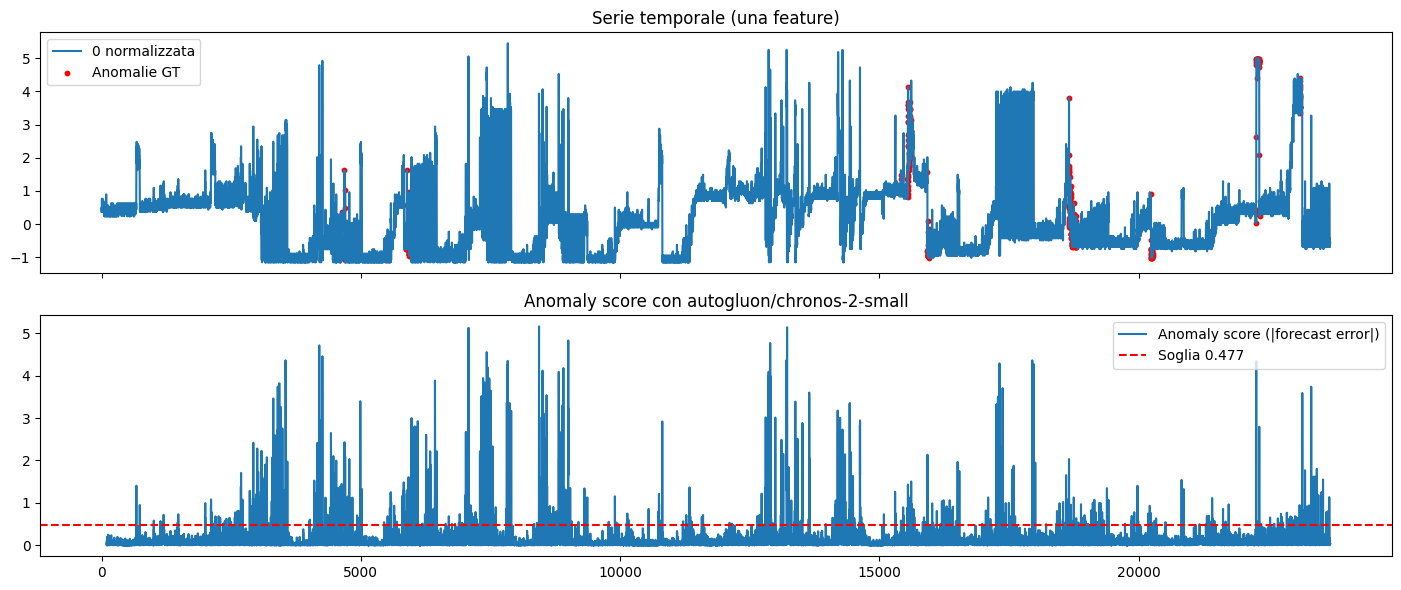

In [26]:
# ============================================================
# 6. Plot per il report
# ============================================================

fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

ax[0].plot(ts_df["timestamp"], ts_df[target_col], label=f"{target_col} normalizzata")
ax[0].scatter(
    ts_df["timestamp"][labels == 1],
    ts_df[target_col][labels == 1],
    color="red",
    s=10,
    label="Anomalie GT",
)
ax[0].legend()
ax[0].set_title("Serie temporale (una feature)")

ax[1].plot(ts_df["timestamp"], score_series, label="Anomaly score (|forecast error|)")
ax[1].axhline(th, color="red", linestyle="--", label=f"Soglia {th:.3f}")
ax[1].legend()
ax[1].set_title("Anomaly score con autogluon/chronos-2-small")

plt.tight_layout()
plt.show()

ora su 4 features poi unite, tempo di esecuzione tipo un ora, troppo



In [27]:
feature_subset = ['0', '1', '2', '3']  # 4 feature max per non appesantire troppo

score_dict = {}

for target_col in feature_subset:
    print("Calcolo score per feature:", target_col)

    y = df[target_col].astype(float).values
    labels = df['Label'].astype(int).values

    # normalizzazione
    scaler = StandardScaler()
    y_norm = scaler.fit_transform(y.reshape(-1, 1)).flatten()

    # ricostruisci ts_df per questa feature
    ts_df = pd.DataFrame({
        "id": "series_1",
        "timestamp": np.arange(len(y_norm)),
        target_col: y_norm,
    })

    # sliding window + predict_df (come prima)
    scores = []
    indices = []

    for t in range(context_len, len(ts_df) - prediction_length + 1):
        ctx_w, fut_w = make_window_df(ts_df, t, context_len, prediction_length)

        pred_df = pipeline.predict_df(
            df=ctx_w,
            prediction_length=prediction_length,
            context_length=context_len,
            id_column="id",
            timestamp_column="timestamp",
            target=[target_col],
        )

        num_cols = [
            c for c in pred_df.columns
            if c not in ["id", "timestamp"] and np.issubdtype(pred_df[c].dtype, np.number)
        ]
        y_pred = float(pred_df[num_cols[0]].iloc[0])
        y_true = float(fut_w[target_col].iloc[0])

        err = abs(y_pred - y_true)
        scores.append(err)
        indices.append(t)

    scores = np.array(scores)
    indices = np.array(indices)

    score_series = np.full(len(ts_df), np.nan, dtype=float)
    score_series[indices] = scores

    score_dict[target_col] = score_series


Calcolo score per feature: 0
Calcolo score per feature: 1
Calcolo score per feature: 2
Calcolo score per feature: 3


In [28]:
# Stack degli score: shape (n_feature, T)
stacked = np.vstack([score_dict[f] for f in feature_subset])
combined_score_max = np.nanmax(stacked, axis=0)

score_series_mv = combined_score_max

labels = df['Label'].astype(int).values

th = np.nanquantile(score_series_mv, 0.95)
pred_labels = (score_series_mv >= th).astype(int)
pred_labels[np.isnan(score_series_mv)] = 0

valid = ~np.isnan(score_series_mv)
y_true_bin = labels[valid]
y_score = score_series_mv[valid]

auc_mv = roc_auc_score(y_true_bin, y_score)
ap_mv = average_precision_score(y_true_bin, y_score)

print("Multivariato (feature:", feature_subset, ")")
print("AUC:", auc_mv)
print("Average Precision:", ap_mv)


Multivariato (feature: ['0', '1', '2', '3'] )
AUC: 0.6778658283633495
Average Precision: 0.056235041639274064


/tmp/ipython-input-2610868338.py:3: RuntimeWarning: All-NaN slice encountered
  combined_score_max = np.nanmax(stacked, axis=0)


Estendendo il metodo a quattro variabili del dataset (calcolo dello score per ciascuna e combinazione tramite funzione max/media) si ottiene uno score “multivariato semplice”, che porta AUC ≈ 0.68 e AP ≈ 0.056. Questo indica che l’informazione congiunta di più feature rende le anomalie leggermente più separabili, pur rimanendo un setting zero‑shot e fortemente sbilanciato.

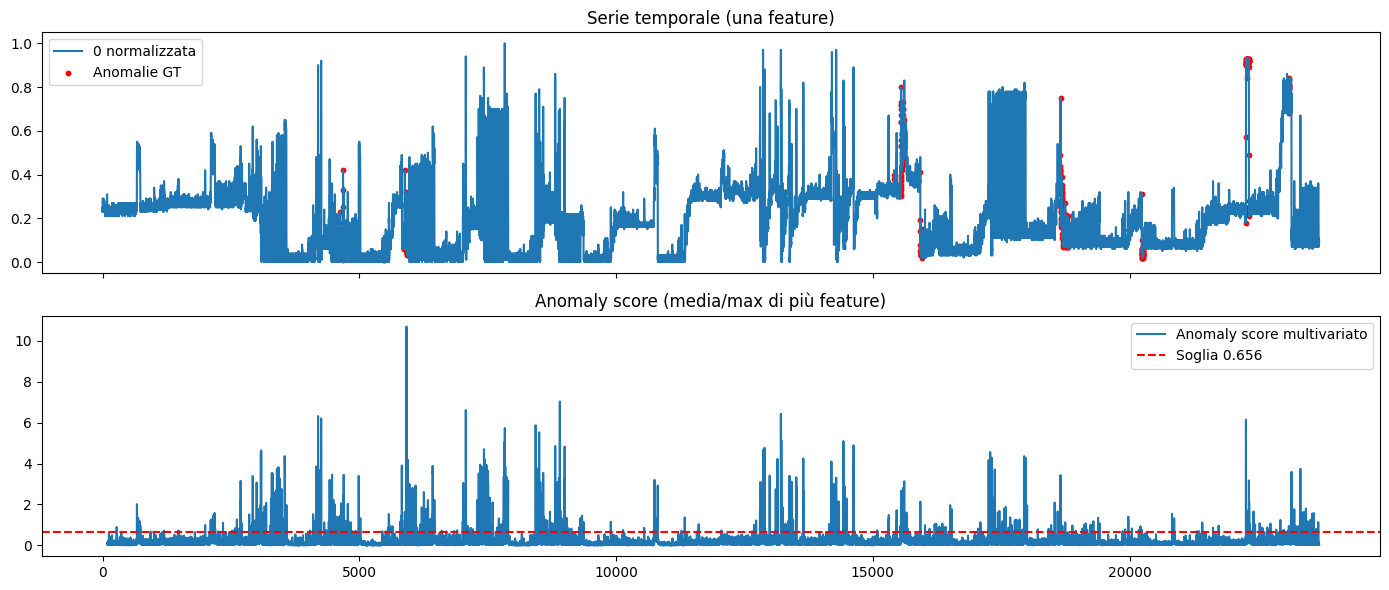

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

ax[0].plot(df.index, df[feature_subset[0]], label=f"{feature_subset[0]} normalizzata")
ax[0].scatter(
    df.index[labels == 1],
    df[feature_subset[0]][labels == 1],
    color="red",
    s=10,
    label="Anomalie GT",
)
ax[0].legend()
ax[0].set_title("Serie temporale (una feature)")

ax[1].plot(df.index, score_series_mv, label="Anomaly score multivariato")
ax[1].axhline(th, color="red", linestyle="--", label=f"Soglia {th:.3f}")
ax[1].legend()
ax[1].set_title("Anomaly score (media/max di più feature)")

plt.tight_layout()
plt.show()


ora tutte e 4 insieme direttamente (non ancora eseguito)

prendiamo un sottoinsieme di feature ['0','1','2','3'], le normalizziamo e costruiamo una serie con id e timestamp; poi, per ogni finestra di contesto di 96 time step, chiediamo al modello di prevedere il vettore di valori al passo successivo su tutte le feature e calcoliamo, come anomaly score, la norma L2 dell’errore tra vettore previsto e vettore osservato. Ripetendo questo sliding window su tutta la serie otteniamo una sequenza di score multivariati, su cui fissiamo una soglia (tipicamente il 95° percentile) per marcare i punti come anomali/non anomali e valutiamo la qualità del detector confrontando le predizioni con la colonna Label del dataset tramite metriche standard di anomaly detection come AUC ROC e Average Precision.

In [34]:
# 1) Dataset multivariato completo (su feature_subset)
df_slice_2 = df_full.reset_index(drop=True)
labels_2 = df_slice_2['Label'].astype(int).values

X_2 = df_slice_2[feature_subset].astype(float).values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm_2 = scaler.fit_transform(X_2)

ts_df_2 = pd.DataFrame(X_norm_2, columns=feature_subset)
ts_df_2['timestamp'] = np.arange(len(ts_df_2))
ts_df_2['id'] = 'series_1'
ts_df_2 = ts_df_2[['id', 'timestamp'] + feature_subset]

In [ ]:
# 3) Sliding window multivariato
scores_2 = []
indices_2 = []

for t in range(context_len, len(ts_df_2) - prediction_length + 1):
    ctx_w, fut_w = make_window_df(ts_df_2, t, context_len, prediction_length)

    pred_df = pipeline.predict_df(
        df=ctx_w,
        prediction_length=prediction_length,
        context_length=context_len,
        id_column="id",
        timestamp_column="timestamp",
        target=feature_subset,   # tutte le feature come target
    )

    # colonne numeriche di forecast (una per feature)
        # colonne numeriche di forecast
    num_cols = [
        c for c in pred_df.columns
        if c not in ["id", "timestamp"] and np.issubdtype(pred_df[c].dtype, np.number)
    ]

    # Mappa feature -> colonna da usare (una per feature)
    selected_cols = []
    for f in feature_subset:
        # tutte le colonne numeriche che contengono il nome della feature
        cand = [c for c in num_cols if f in str(c)]
        if len(cand) == 0:
            raise RuntimeError(f"Nessuna colonna di forecast trovata per feature {f}")
        # prendi la prima colonna candidata per quella feature
        selected_cols.append(cand[0])

    # ora selected_cols ha esattamente len(feature_subset) colonne
    pred_vec = pred_df[selected_cols].iloc[0].values.astype(float)   # shape (len(feature_subset),)
    true_vec = fut_w[feature_subset].iloc[0].values.astype(float)    # shape (len(feature_subset),)

    err = float(np.linalg.norm(pred_vec - true_vec))  # errore L2 multivariato

scores_2 = np.array(scores_2)
indices_2 = np.array(indices_2)

score_series_2 = np.full(len(ts_df_2), np.nan, dtype=float)
score_series_2[indices_2] = scores_2


In [ ]:
# 4) Metriche sullo score multivariato
th_2 = np.nanquantile(score_series_2, 0.95)
pred_labels_2 = (score_series_2 >= th_2).astype(int)
pred_labels_2[np.isnan(score_series_2)] = 0

valid_2 = ~np.isnan(score_series_2)
y_true_bin_2 = labels_2[valid_2]
y_score_2 = score_series_2[valid_2]

from sklearn.metrics import roc_auc_score, average_precision_score
auc_mv = roc_auc_score(y_true_bin_2, y_score_2)
ap_mv = average_precision_score(y_true_bin_2, y_score_2)

print("Multivariato vero (feature:", feature_subset, ")")
print("AUC:", auc_mv)
print("Average Precision:", ap_mv)